In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, iv, kv
from scipy.integrate import quad, IntegrationWarning
import warnings
import time

In [28]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 20})

In [26]:
# Suppress integration warnings
warnings.filterwarnings('ignore', category=IntegrationWarning)

# Constants
G = 1  # Gravitational constant (set to 1 for simplicity)
Sigma0 = 1  # Central surface mass density
Rd = 1  # Disk scale length
Md = 2 * np.pi * Sigma0 * Rd**2  # Total mass of the disk

# Define the surface mass density function for the exponential disk
def Sigma(R):
    return Sigma0 * np.exp(-R / Rd)

# Compute f(k) using the Hankel transform of Sigma(R)
def f_k(k):
    # Integrate from R_min to R_max
    R_min = 0.0
    R_max = 50 * Rd  # Upper limit should be sufficiently large
    # Define the integrand
    def integrand(R):
        return Sigma(R) * j0(k * R) * R
    # Perform the integration
    result, _ = quad(integrand, R_min, R_max, limit=1000)
    return -2 * np.pi * G * result

# Vectorize f_k for array inputs
f_k_vec = np.vectorize(f_k)

# Prepare k values for integration
k_values = np.linspace(0.001 / Rd, 50 / Rd, 500)  # Avoid k = 0 to prevent division by zero

# Compute f(k) values
print("Computing f(k) values...")
start_time = time.time()
f_k_values = f_k_vec(k_values)
print(f"Completed computing f(k) in {time.time() - start_time:.2f} seconds")

# Create a grid in R and z
R_values = np.linspace(0.1 * Rd, 10 * Rd, 1000)
z_values = np.linspace(-5 * Rd, 5 * Rd, 1000)
R_grid, z_grid = np.meshgrid(R_values, z_values)

# Function to compute Phi at a point (R, z)
def Phi_point(R, z):
    integrand = f_k_values * j0(k_values * R) * np.exp(-k_values * np.abs(z))
    result = np.trapz(integrand, k_values)
    return result

# Vectorize Phi_point for array inputs
Phi_vec = np.vectorize(Phi_point)

# Compute Phi on the grid
print("Computing potential grid...")
start_time = time.time()
Phi_grid = Phi_vec(R_grid, z_grid)
print(f"Completed computing potential grid in {time.time() - start_time:.2f} seconds")

# Normalize potential with Phi_norm
Phi_norm = G * Md / Rd
Phi_grid_normalized = Phi_grid / Phi_norm

Computing f(k) values...
Completed computing f(k) in 1.76 seconds
Computing potential grid...
Completed computing potential grid in 31.69 seconds


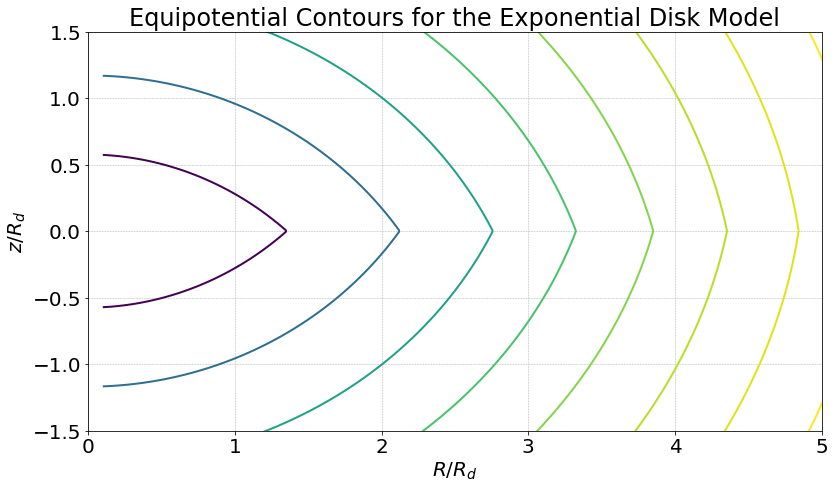

In [51]:
# Plot width
width = 12
# Range of R/R_d and z/R_d to show
Rmax_plot = 5
zmax_plot = 1.5

# Define contour levels in units of Phi_norm divided by 1.5, 2, 2.5, etc.
# Since the potential is negative, we'll use negative values for levels
levels_multiplier = np.array([1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
contour_levels = -1 / levels_multiplier  # Negative because potential is negative

# Ensure contour levels are within the range of Phi_grid_normalized
Phi_min = np.min(Phi_grid_normalized)
Phi_max = np.max(Phi_grid_normalized)

# Adjust contour levels if necessary
contour_levels = contour_levels[(contour_levels > Phi_min) & (contour_levels < Phi_max)]

# Plot equipotential contours
plt.figure(figsize=(width, width*2*zmax_plot/Rmax_plot))
contour = plt.contour(R_grid / Rd, z_grid / Rd, Phi_grid_normalized, levels=contour_levels, 
                      cmap='viridis', linewidths=2)

plt.title('Equipotential Contours for the Exponential Disk Model')
plt.xlabel('$R / R_d$')
plt.ylabel('$z / R_d$')
plt.xlim(0,Rmax_plot)
plt.ylim(-zmax_plot,zmax_plot)


plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("../Figures/exponential_disk_potential.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

Computing rotation curve...
Completed computing rotation curve in 0.03 seconds


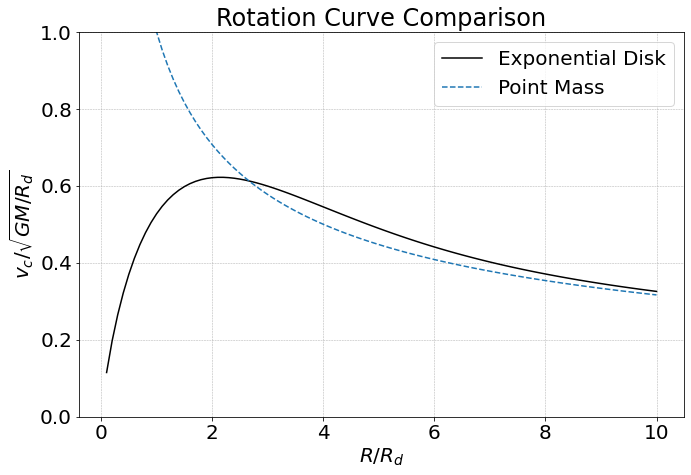

In [47]:
# Define the normalization factor sqrt(GM/R_d)
vc_unit = np.sqrt(G * Md / Rd)

# Compute the rotation curve numerically
def vc_numerical(R):
    # Compute the derivative of the potential numerically
    delta_R = 1e-5 * Rd  # Small increment in R
    Phi_R_plus = Phi_vec(R + delta_R, 0)
    Phi_R_minus = Phi_vec(R - delta_R, 0)
    dPhi_dR = (Phi_R_plus - Phi_R_minus) / (2 * delta_R)
    return np.sqrt(R * dPhi_dR) / vc_unit  # Normalize by sqrt(GM/R_d)

print("Computing rotation curve...")
start_time = time.time()
R_vc = np.linspace(0.1 * Rd, 10 * Rd, 100)
vc_values_numerical = np.array([vc_numerical(R) for R in R_vc])
print(f"Completed computing rotation curve in {time.time() - start_time:.2f} seconds")

# Compute the rotation curve using the analytical expression for comparison
def vc_analytical(R):
    y = R / (2 * Rd)
    term = y**2 * (iv(0, y) * kv(0, y) - iv(1, y) * kv(1, y))
    return np.sqrt(4 * np.pi * G * Sigma0 * Rd * term) / vc_unit  # Normalize by sqrt(GM/R_d)

vc_values_analytical = vc_analytical(R_vc)

# Rotation curve for a point mass with the same total mass
vc_point_mass = np.sqrt(G * Md / R_vc) / vc_unit  # Normalize by sqrt(GM/R_d)

# Plot the rotation curves
plt.figure(figsize=(10, 7))
plt.plot(R_vc / Rd, vc_values_analytical, label='Exponential Disk', color='black')
plt.plot(R_vc / Rd, vc_point_mass, label='Point Mass', linestyle='--', color='tab:blue')

plt.title('Rotation Curve Comparison')
plt.xlabel('$R / R_d$')
plt.ylabel('$v_c / \sqrt{GM / R_d}$')
plt.ylim(0, 1.)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("../Figures/exponential_disk_rotation_curve.png", format="png", dpi=300, bbox_inches='tight')
plt.show()
